In [1]:
using Pkg
Pkg.activate(".")
using qsrfe

  Activating project at `c:\Users\grsbe\Desktop\Masterthesis\qsrfe`


In [1]:
include("src/qsrfe.jl")
using .qsrfe

In [2]:

using Plots


In [8]:
function abs_error(y_truth, y_pred)
    mean(abs.(y_truth - y_pred))
end

abs_error (generic function with 1 method)

In [173]:
#2^8 = 256, 2^9 = 512, 2^10 = 1024, 2^11 = 2048, 2^12 = 4096, 2^13 = 8192, 2^14 = 16384

MSQ2 = MSQ(K=2)
MSQ4 = MSQ(K=16)
MSQ8 = MSQ(K=256)

λ_c = 16
p = N ÷ λ_c
model2 = srfeRegressor(N= p*λ_c,λ=λ, σ2=1.0)

ΣΔ1Q2 = ΣΔQ(K=2,r=1,λ=λ_c,condense=true)
ΣΔ1Q4 = ΣΔQ(K=16,r=1,λ=λ_c,condense=true)
ΣΔ1Q8 = ΣΔQ(K=256,r=1,λ=λ_c,condense=true)

βQ2 = βQ(K=2,β=1.5,λ=λ_c,condense=true)
βQ4 = βQ(K=16,β=1.5,λ=λ_c,condense=true)
βQ8 = βQ(K=256,β=1.5,λ=λ_c,condense=true);

In [228]:
#boston dataset
using LinearAlgebra
using MLJ, MLJLinearModels
X, Y = @load_boston
(xtrain, xtest), (ytrain, ytest) = load_dataset(X,Y;normalize=true,partitioning=0.5,rng=1234);
indexmaptrain = ytrain .<= 47
indexmaptest = ytest .<= 44
(xtrain, xtest), (ytrain, ytest) = (xtrain[indexmaptrain,:], xtest[indexmaptest,:]), (ytrain[indexmaptrain], ytest[indexmaptest])

(([0.0005258688489131264 0.0428728179250255 … 0.04792704786097089 0.02059703773458206; 0.08821644274022668 0.0 … 0.04792704786097089 0.11620646698099267; … ; 0.0005998824930151644 0.07717107226504591 … 0.04622925422800226 0.013955793769642523; 0.00027607280006874843 0.02143640896251275 … 0.04784372797428893 0.024789896827654482], [0.0006635475799199457 0.0 … 0.04792704786097089 0.04495846720965979; 0.0017594454803483164 0.03772807977402244 … 0.04792704786097089 0.01083410305801196; … ; 0.007135830924146997 0.0 … 0.04124938158051816 0.040643188872994014; 0.0024826045648607543 0.0 … 0.046906681132764284 0.029196989597015277]), ([22.2, 13.8, 22.0, 14.6, 27.5, 25.3, 12.7, 14.4, 12.7, 25.0  …  27.1, 37.6, 24.6, 19.9, 30.3, 23.2, 21.4, 17.5, 29.8, 22.0], [23.1, 42.8, 10.8, 10.4, 10.9, 28.7, 26.4, 24.3, 14.0, 11.8  …  23.4, 20.3, 10.5, 22.9, 16.7, 19.9, 15.7, 21.4, 19.6, 25.1]))

In [ ]:
#other datasets here

In [229]:
#test cell for hyperparameter testing
#model = model
N= 2^10
λ = 0.001
model = srfeRegressor(N=N,λ=λ, σ2=1.0)

c, ω, ζ = qsrfe.fit(model,xtrain,ytrain;max_iter=2000000,verbose=true)
ytrainpred = qsrfe.predict(model,xtrain,c, ω, ζ)
ytestpred = qsrfe.predict(model,xtest,c, ω, ζ);

println("")
println("rel: ",rel_error(ytest,ytestpred)," train rel: ",rel_error(ytrain,ytrainpred))
println("abs: ",abs_error(ytest,ytestpred)," train abs: ",abs_error(ytrain,ytrainpred))
println("mse: ",mse(ytest,ytestpred)," train mse: ",mse(ytrain,ytrainpred))

support: 821/1024
rel: 0.14036437468621854 train rel: 0.11073762544384931
abs: 2.7240002945048305 train abs: 2.0414310605967816
mse: 15.466973646915491 train mse: 7.341640186305888


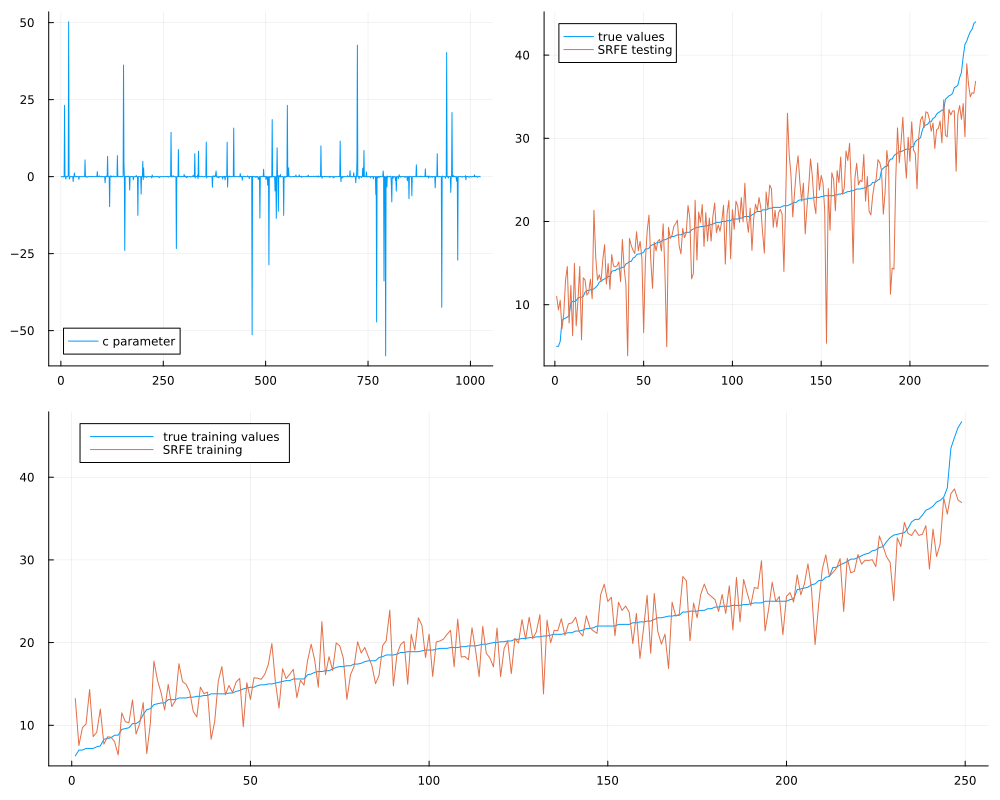

In [230]:
p1 = plot(c[1:(end - model.intercept)],label="c parameter")
p2 = plot(ytrain[sortperm(ytrain)], label="true training values")
plot!(ytrainpred[sortperm(ytrain)], label="SRFE training")
p3 = plot(ytest[sortperm(ytest)], label="true values")
plot!(ytestpred[sortperm(ytest)], label="SRFE testing")
p4 = plot(p1,p3,layout=2, size = (1000,400))
plot(p4,p2,layout=(2,1) ,size=(1000,800))

In [ ]:
#test cell for hyperparameter testing quantized version
#model =
quantizer = 
c, ω, ζ = qsrfe.fit(model,xtrain,ytrain,quantizer;verbose=TRUE)
ytrainpred = qsrfe.predict(model,quantizer,xtrain,c, ω, ζ)
ytestpred = qsrfe.predict(model,quantizer,xtest,c, ω, ζ)
p1 = plot(c[1:(end - model.intercept)],label="c parameter")
p2 = plot(ytrain[1:end], label="true values")
plot!(ytrainpred[1:end], label="SRFE")
plot(p1,p2,layout=2,size=(1000,400))